In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.0 MB/s eta 0:00:00


In [ ]:
# Library
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout, LSTM, Input
from pmdarima.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

# Function

In [ ]:
# utils
def mean_absolute_percentage_error(y_true, y_pred) :
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
# convert an array of values into a dataset matrix
def split_sequence(sequence, n_steps=1):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# make a forecast
def forecast(model, history, n_steps):
	# flatten data
	data = np.array(history)
	# retrieve last observations for input data
	input_x = data[-n_steps:, :]
	# reshape into [1, n_input, p]
	input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
	# forecast
	yhat = model.predict(input_x, verbose=0)
	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# Import Dataset

In [ ]:
my_data = pd.read_csv('/content/aftersidangdata 2.csv')
my_data.set_index('Date', inplace=True)

In [ ]:
my_data.head()

,Hidrokortison SK,Ibuprofen 200 mg,Ibupropen 400 mg,Ibupropen syrup,Isosorbid dinitrat,Kalsium Diclofenac,Kalsium Laktat,Ketokonazol salep,Ketokonazol tablet,Lansoprazol 30 mg,...,Ispa,Commoncold,Hypertensi,Cepalgia,Dermatitis,Otitis arthritis,Myalgia,Gimul,Konjungtivitis,Dyspebsia
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2016,0,1357,717,0,0,0,2052,39,98,0,...,327,275,207,164,200,81,163,157,64,215
4/1/2016,0,881,605,0,2,0,0,39,265,0,...,373,297,230,237,250,73,209,185,33,252
7/1/2016,0,1752,1781,0,61,0,0,41,183,0,...,443,322,299,158,262,158,198,239,97,250
10/1/2016,0,2180,1579,0,15,0,974,39,334,986,...,386,320,256,146,236,123,219,211,53,227
1/1/2017,0,4321,4849,0,6,0,0,42,144,890,...,310,269,209,187,200,146,155,177,60,193


In [ ]:
my_data = my_data.astype("float32")

In [ ]:
my_data.shape

(30, 82)

In [ ]:
my_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 1/1/2016 to 4/1/2023
Data columns (total 82 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Hidrokortison SK                   30 non-null     float32
 1   Ibuprofen 200 mg                   30 non-null     float32
 2   Ibupropen 400 mg                   30 non-null     float32
 3   Ibupropen syrup                    30 non-null     float32
 4   Isosorbid dinitrat                 30 non-null     float32
 5   Kalsium Diclofenac                 30 non-null     float32
 6   Kalsium Laktat                     30 non-null     float32
 7   Ketokonazol salep                  30 non-null     float32
 8   Ketokonazol tablet                 30 non-null     float32
 9   Lansoprazol 30 mg                  30 non-null     float32
 10  Laxarec                            30 non-null     float32
 11  Loperamid                          30 non-null     f

In [ ]:
my_data

,Hidrokortison SK,Ibuprofen 200 mg,Ibupropen 400 mg,Ibupropen syrup,Isosorbid dinitrat,Kalsium Diclofenac,Kalsium Laktat,Ketokonazol salep,Ketokonazol tablet,Lansoprazol 30 mg,...,Ispa,Commoncold,Hypertensi,Cepalgia,Dermatitis,Otitis arthritis,Myalgia,Gimul,Konjungtivitis,Dyspebsia
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2016,0.0,1357.0,717.0,0.0,0.0,0.0,2052.0,39.0,98.0,0.0,...,327.0,275.0,207.0,164.0,200.0,81.0,163.0,157.0,64.0,215.0
4/1/2016,0.0,881.0,605.0,0.0,2.0,0.0,0.0,39.0,265.0,0.0,...,373.0,297.0,230.0,237.0,250.0,73.0,209.0,185.0,33.0,252.0
7/1/2016,0.0,1752.0,1781.0,0.0,61.0,0.0,0.0,41.0,183.0,0.0,...,443.0,322.0,299.0,158.0,262.0,158.0,198.0,239.0,97.0,250.0
10/1/2016,0.0,2180.0,1579.0,0.0,15.0,0.0,974.0,39.0,334.0,986.0,...,386.0,320.0,256.0,146.0,236.0,123.0,219.0,211.0,53.0,227.0
1/1/2017,0.0,4321.0,4849.0,0.0,6.0,0.0,0.0,42.0,144.0,890.0,...,310.0,269.0,209.0,187.0,200.0,146.0,155.0,177.0,60.0,193.0
4/1/2017,0.0,5590.0,3614.0,0.0,53.0,0.0,0.0,32.0,143.0,1255.0,...,230.0,237.0,192.0,209.0,143.0,94.0,193.0,154.0,90.0,187.0
7/1/2017,0.0,413.0,4355.0,0.0,2.0,0.0,0.0,78.0,152.0,3252.0,...,421.0,283.0,265.0,229.0,222.0,73.0,234.0,179.0,129.0,152.0
10/1/2017,39.0,1536.0,6149.0,0.0,0.0,0.0,365.0,27.0,146.0,2718.0,...,484.0,38.0,316.0,251.0,243.0,14.0,261.0,245.0,12.0,252.0
1/1/2018,44.0,1955.0,4180.0,10.0,0.0,0.0,560.0,64.0,286.0,1384.0,...,495.0,117.0,228.0,256.0,284.0,0.0,300.0,286.0,0.0,263.0


# Preprocessing Data

In [ ]:
my_data.describe()

,Hidrokortison SK,Ibuprofen 200 mg,Ibupropen 400 mg,Ibupropen syrup,Isosorbid dinitrat,Kalsium Diclofenac,Kalsium Laktat,Ketokonazol salep,Ketokonazol tablet,Lansoprazol 30 mg,...,Ispa,Commoncold,Hypertensi,Cepalgia,Dermatitis,Otitis arthritis,Myalgia,Gimul,Konjungtivitis,Dyspebsia
count,30.000000,30.000000,30.000000,30.000000,30.0000,30.0,30.000000,30.000000,30.000000,30.000000,...,30.000000,30.000000,30.000000,30.00000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,37.533333,2411.500000,2456.500000,16.700001,10.5000,0.0,718.599976,39.200001,147.966660,1263.233276,...,315.899994,233.033340,214.699997,182.03334,201.566666,76.599998,190.533340,178.066666,75.000000,184.033340
std,29.607470,2210.771729,1731.916016,19.527433,18.4461,0.0,525.029663,15.446012,105.553543,889.767883,...,118.453934,76.612091,64.716438,56.38261,47.728893,63.015926,60.922638,52.590767,55.141197,63.271984
min,0.000000,0.000000,0.000000,0.000000,0.0000,0.0,0.000000,17.000000,0.000000,0.000000,...,160.000000,38.000000,107.000000,90.00000,124.000000,0.000000,45.000000,98.000000,0.000000,44.000000
25%,13.750000,530.000000,983.750000,0.000000,0.0000,0.0,413.750000,31.250000,63.500000,644.250000,...,231.250000,202.500000,170.500000,138.50000,163.250000,16.750000,164.000000,142.000000,38.250000,137.750000
50%,39.500000,1941.000000,2156.500000,11.500000,1.0000,0.0,746.000000,38.500000,144.500000,1223.000000,...,283.000000,222.500000,208.000000,181.00000,200.000000,76.500000,194.000000,169.500000,64.500000,185.500000
75%,53.750000,3665.250000,3592.000000,24.500000,12.7500,0.0,921.000000,44.250000,187.500000,1811.000000,...,407.750000,280.250000,263.500000,213.50000,242.500000,118.750000,225.000000,221.250000,99.250000,226.000000
max,107.000000,7856.000000,6149.000000,63.000000,61.0000,0.0,2052.000000,80.000000,360.000000,3252.000000,...,589.000000,468.000000,322.000000,335.00000,287.000000,248.000000,310.000000,286.000000,231.000000,312.000000


In [ ]:
# seperate y and exogenous X
Y = my_data.iloc[:,0:72]
X = my_data.iloc[:,72:]

In [ ]:
X

,Ispa,Commoncold,Hypertensi,Cepalgia,Dermatitis,Otitis arthritis,Myalgia,Gimul,Konjungtivitis,Dyspebsia
Date,,,,,,,,,,
1/1/2016,327.0,275.0,207.0,164.0,200.0,81.0,163.0,157.0,64.0,215.0
4/1/2016,373.0,297.0,230.0,237.0,250.0,73.0,209.0,185.0,33.0,252.0
7/1/2016,443.0,322.0,299.0,158.0,262.0,158.0,198.0,239.0,97.0,250.0
10/1/2016,386.0,320.0,256.0,146.0,236.0,123.0,219.0,211.0,53.0,227.0
1/1/2017,310.0,269.0,209.0,187.0,200.0,146.0,155.0,177.0,60.0,193.0
4/1/2017,230.0,237.0,192.0,209.0,143.0,94.0,193.0,154.0,90.0,187.0
7/1/2017,421.0,283.0,265.0,229.0,222.0,73.0,234.0,179.0,129.0,152.0
10/1/2017,484.0,38.0,316.0,251.0,243.0,14.0,261.0,245.0,12.0,252.0
1/1/2018,495.0,117.0,228.0,256.0,284.0,0.0,300.0,286.0,0.0,263.0


In [ ]:
Y

,Hidrokortison SK,Ibuprofen 200 mg,Ibupropen 400 mg,Ibupropen syrup,Isosorbid dinitrat,Kalsium Diclofenac,Kalsium Laktat,Ketokonazol salep,Ketokonazol tablet,Lansoprazol 30 mg,...,Vit. B 12,Vit. B 6,Vit. B Complex,Vit. C 10 mg,Vit. C 50 mg,Vit. C 500 mg,Vit. K,Whitfield,Yodium Povidon,Zinc 20 mg
Date,,,,,,,,,,,,,,,,,,,,,
1/1/2016,0.0,1357.0,717.0,0.0,0.0,0.0,2052.0,39.0,98.0,0.0,...,0.0,0.0,1207.0,0.0,0.0,0.0,0.0,0.0,3.0,1100.0
4/1/2016,0.0,881.0,605.0,0.0,2.0,0.0,0.0,39.0,265.0,0.0,...,500.0,0.0,500.0,0.0,0.0,0.0,0.0,0.0,7.0,720.0
7/1/2016,0.0,1752.0,1781.0,0.0,61.0,0.0,0.0,41.0,183.0,0.0,...,0.0,0.0,0.0,0.0,2064.0,0.0,0.0,0.0,4.0,806.0
10/1/2016,0.0,2180.0,1579.0,0.0,15.0,0.0,974.0,39.0,334.0,986.0,...,40.0,0.0,1082.0,0.0,3205.0,0.0,0.0,0.0,12.0,830.0
1/1/2017,0.0,4321.0,4849.0,0.0,6.0,0.0,0.0,42.0,144.0,890.0,...,130.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,586.0
4/1/2017,0.0,5590.0,3614.0,0.0,53.0,0.0,0.0,32.0,143.0,1255.0,...,143.0,0.0,715.0,0.0,0.0,0.0,0.0,0.0,0.0,426.0
7/1/2017,0.0,413.0,4355.0,0.0,2.0,0.0,0.0,78.0,152.0,3252.0,...,282.0,0.0,1038.0,0.0,0.0,0.0,0.0,0.0,7.0,514.0
10/1/2017,39.0,1536.0,6149.0,0.0,0.0,0.0,365.0,27.0,146.0,2718.0,...,20.0,0.0,1038.0,0.0,0.0,0.0,0.0,0.0,2.0,490.0
1/1/2018,44.0,1955.0,4180.0,10.0,0.0,0.0,560.0,64.0,286.0,1384.0,...,908.0,333.0,0.0,0.0,654.0,0.0,0.0,0.0,13.0,0.0


# MODEL

# define model 5
def LSTM_Model(input_Shape):

    inputs = Input(input_Shape)

    x = LSTM(64, return_sequences=True)(inputs)
    x = LSTM(64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32)(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inputs, outputs = x)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# define model 2
def LSTM_Model(input_Shape):

    inputs = Input(input_Shape)

    x = LSTM(256, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(128)(x)
    x = Dropout(0.1)(x)
    x = Dense(128)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inputs, outputs = x)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# define model 1
def LSTM_Model(input_Shape):

    inputs = Input(input_Shape)

    x = LSTM(32, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(16)(x)
    x = Dropout(0.1)(x)
    x = Dense(1)(x)

    model = Model(inputs = inputs, outputs = x)
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

# DEFINE MODEL

In [ ]:
# define model 2
def LSTM_Model(input_Shape):

    inputs = Input(input_Shape)

    x = LSTM(256, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)
    x = LSTM(128)(x)
    x = Dropout(0.1)(x)
    x = Dense(128)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs = inputs, outputs = x)
    model.compile(loss='mean_squared_error', optimizer='Adam')

    return model

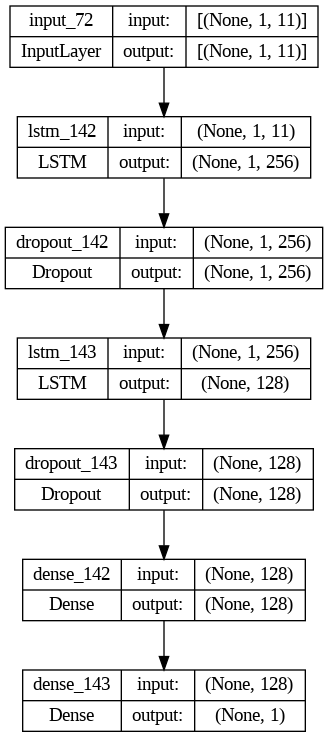

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

# Modelling And Evaluation

In [ ]:
import os

# Buat direktori bernama `images`
os.mkdir("images")

In [ ]:
# random seeds
def reset_seeds():
   np.random.seed(333)
   random.seed(333)
   tf.random.set_seed(333)

reset_seeds()

# define container
mymodel = []
evaluation = []
forcasting = []

# looping for all Y dependents
for index, values in enumerate(Y.columns):
    # concatenate
    combined = pd.concat([X, Y[[values]]], axis=1).values

    # scale data
    scaler = MinMaxScaler(feature_range=(0,1)).fit(combined)
    scaled_combined = scaler.transform(combined)

    #split data into train and training set (70:30)
    scaled_train_combined, scaled_test_combined  = train_test_split(scaled_combined, test_size=0.30)

    # reshape X and Y
    n_steps = 1 # number of time lag
    trainX, trainY = split_sequence(scaled_train_combined, n_steps)
    testX, testY = split_sequence(scaled_test_combined, n_steps)

    # fit LSTM network
    model = LSTM_Model((trainX.shape[1],trainX.shape[2]))
    hist = model.fit(trainX, trainY[:,-1].reshape(-1,1), epochs=100, batch_size=2,
                    validation_data=(testX, testY[:,-1].reshape(-1,1)), verbose=0, shuffle=False)
    mymodel.append(model)

    # plot performance
    fig = plt.figure(figsize=(16,10), dpi=600)
    plt.plot(hist.history['loss'], color= 'black', scaley=1)
    plt.plot(hist.history['val_loss'], color='gold')
    plt.title(f'Model Loss for {values}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.ylim(0, 1)
    plt.savefig(f'images/model_loss_{values}.png')
    plt.close(fig)

    # make a prediction for train set
    yhat = np.concatenate((scaled_combined[:n_steps, -1].reshape(-1,1), model.predict(trainX, verbose=0)))

    # make a prediction for test set
    history = [x for x in scaled_train_combined]
    # walk-forward forecasting
    predictions = list()
    for i in range(len(scaled_test_combined)):
        # predict
        yhat_sequence = forecast(model, history, n_steps)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting
        history.append(scaled_test_combined[i,:])

    # evaluate forecasts
    predic = np.concatenate((yhat, predictions))
    lstm_preds = scaler.inverse_transform(np.concatenate((scaled_combined[:, :-1], predic), axis=1))
    rmse = math.sqrt(mean_squared_error(combined[1:,-1], lstm_preds[1:,-1]))
    mape = mean_absolute_percentage_error(combined[1:,-1], lstm_preds[1:,-1])
    rsq = np.corrcoef(combined[1:,-1], lstm_preds[1:,-1])[0,1]**2
    evaluation.append({"Outputs": values, "RMSE": rmse, "MAPE": mape, "R Square": rsq})
    forcasting.append(lstm_preds[:,-1])

    print(f'Evaluation Result for {values} :')
    print('RMSE : %.3f' % rmse)
    print('MAPE : %.3f' % mape)
    print('R Square : %.3f' % rsq)

    # plot forecasts against actual outcomes
    fig = plt.figure(figsize=(16,10), dpi=600)
    plt.plot(axis='Y[values].index', labelrotation=90)
    plt.plot(Y[values].index[1:], Y[values].values[1:], color = 'gold', label=f'Actual {values}')
    plt.plot(Y[values].index[1:], lstm_preds[1:,-1], color = 'black',label='Predicted train set')
    plt.plot(Y[values].index[-8:], lstm_preds[-8:,-1], color = 'red',label='Predicted test set')
    plt.xticks(Y[values].index, rotation='vertical')
    plt.xlabel('Periode Waktu')
    plt.ylabel(f'{values}')
    plt.legend(loc='upper left', fontsize=8)
    plt.savefig(f'images/Prediction_{values}.png')
    plt.close(fig)

    # Lstm Feature Importance
    X_valid = trainX.copy()
    results = []

    oof_preds = model.predict(X_valid, verbose=0).squeeze()
    baseline_mae = np.mean(np.abs(oof_preds-trainY[:,-1]))
    results.append({'feature':'BASELINE','mae': baseline_mae})

    for k in range(len(X.columns)):
        # shuffle feature k
        save_col = X_valid[:,:,k].copy()
        np.random.shuffle(X_valid[:,:,k])

        # Compute OOF MAE With Feature K Shuffled
        oof_preds = model.predict(X_valid, verbose=0).squeeze()
        mae = np.mean(np.abs(oof_preds-trainY[:,-1]))
        results.append({'feature': X.columns[k],'mae': mae})
        X_valid[:,:,k] = save_col

    # Display Lstm Feature Importance
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    fig = plt.figure(figsize=(7,5))
    plt.barh(np.arange(len(X.columns) + 1),df.mae)
    plt.yticks(np.arange(len(X.columns)+1),df.feature.values)
    plt.title(f'LSTM Feature Importance for {values}')
    plt.ylim((-1,len(X.columns)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(X.columns)+1], '--', color='orange',
                label=f'Baseline OOF\n MAE={baseline_mae:.3f}')
    plt.xlabel(f'Permutation Feature Importance')
    plt.ylabel('Feature')
    plt.legend()
    plt.savefig(f'images/Feature Importance_{values}.png', bbox_inches='tight')
    plt.close(fig)

Evaluation Result for Hidrokortison SK :
RMSE : 14.624
MAPE : inf
R Square : 0.778
Evaluation Result for Ibuprofen 200 mg :
RMSE : 1056.723
MAPE : inf
R Square : 0.779
Evaluation Result for Ibupropen 400 mg :
RMSE : 1435.698
MAPE : inf
R Square : 0.361
Evaluation Result for Ibupropen syrup :
RMSE : 8.743
MAPE : inf
R Square : 0.797
Evaluation Result for Isosorbid dinitrat :
RMSE : 14.339
MAPE : inf
R Square : 0.422
Evaluation Result for Kalsium Diclofenac :
RMSE : 0.005
MAPE : inf
R Square : nan
Evaluation Result for Kalsium Laktat :
RMSE : 415.333
MAPE : inf
R Square : 0.387
Evaluation Result for Ketokonazol salep :
RMSE : 12.259
MAPE : 29.956
R Square : 0.466
Evaluation Result for Ketokonazol tablet :
RMSE : 77.166
MAPE : inf
R Square : 0.523
Evaluation Result for Lansoprazol 30 mg :
RMSE : 609.408
MAPE : inf
R Square : 0.513
Evaluation Result for Laxarec :
RMSE : 0.005
MAPE : inf
R Square : nan
Evaluation Result for Loperamid :
RMSE : 0.005
MAPE : inf
R Square : nan
Evaluation Resul

In [ ]:
pip install xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
# save forecasting & evaluation result
writer = pd.ExcelWriter("evaluation output.xlsx", engine = 'xlsxwriter')
df1 = pd.DataFrame(np.array(forcasting).T, index= Y.index, columns = Y.columns)
df2 = pd.DataFrame(evaluation)
df1.to_excel(writer, sheet_name='forecasting')
df2.to_excel(writer, sheet_name='evaluation', index=False)
writer.close()

In [ ]:
!zip -r /content/images.zip /content/images

  adding: content/images/ (stored 0%)
  adding: content/images/model_loss_Nistatin tablet.png (deflated 60%)
  adding: content/images/Feature Importance_Hidrokortison SK.png (deflated 13%)
  adding: content/images/Feature Importance_Kalsium Laktat.png (deflated 13%)
  adding: content/images/Feature Importance_New Antides.png (deflated 13%)
  adding: content/images/Feature Importance_Tablet tambah darah.png (deflated 12%)
  adding: content/images/model_loss_Kalsium Laktat.png (deflated 49%)
  adding: content/images/model_loss_Metronidazol 500 mg.png (deflated 52%)
  adding: content/images/model_loss_SF.png (deflated 53%)
  adding: content/images/Feature Importance_Metronidazol 500 mg.png (deflated 13%)
  adding: content/images/Prediction_Risperidon 2 mg.png (deflated 39%)
  adding: content/images/model_loss_Methylergometrine tablet.png (deflated 68%)
  adding: content/images/Prediction_Methylprednisolon.png (deflated 30%)
  adding: content/images/model_loss_Rifamficin.png (deflated 70%)

In [ ]:
trainX.shape

(18, 3, 10)

In [ ]:
trainY.shape

(18, 10)

In [ ]:
testX.shape

(6, 3, 10)

In [ ]:
testY.shape

(6, 10)

In [ ]:
model.summary()

Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 3, 10)]           0         
                                                                 
 lstm_80 (LSTM)              (None, 3, 256)            273408    
                                                                 
 dropout_80 (Dropout)        (None, 3, 256)            0         
                                                                 
 lstm_81 (LSTM)              (None, 128)               197120    
                                                                 
 dropout_81 (Dropout)        (None, 128)               0         
                                                                 
 dense_80 (Dense)            (None, 128)               16512     
                                                                 
 dense_81 (Dense)            (None, 1)                 129

# WEIGHT AND BIAS

In [ ]:
lstm_layer = model.layers[1]

In [ ]:
kernel_initializer = lstm_layer.kernel_initializer

In [ ]:
config = kernel_initializer.get_config()

In [ ]:
print("Fungsi Inisialisasi Default untuk Bobot Kernel:", kernel_initializer.__class__.__name__)

Fungsi Inisialisasi Default untuk Bobot Kernel: GlorotUniform


In [ ]:
# Mendapatkan layer LSTM pertama
lstm_layer_1 = model.layers[1]

# Mendapatkan nilai default inisialisasi bobot kernel dan bias pada layer LSTM pertama
weights = lstm_layer_1.get_weights()

# Pisahkan bobot untuk masing-masing gate
W_i, W_f, W_c, W_o = weights[0][:, :128], weights[0][:, 128:256], weights[0][:, 256:384], weights[0][:, 384:]

# Pisahkan bias untuk masing-masing gate
b_i, b_f, b_c, b_o = weights[2][:128], weights[2][128:256], weights[2][256:384], weights[2][384:]

# Output nilai default inisialisasi untuk bobot setiap gate
print("Inisialisasi untuk Bobot Input Gate (W_i):", W_i)
print("Inisialisasi untuk Bobot Forget Gate (W_f):", W_f)
print("Inisialisasi untuk Bobot Cell Candidate (W_c):", W_c)
print("Inisialisasi untuk Bobot Output Gate (W_o):", W_o)

# Output nilai default inisialisasi untuk bias setiap gate
print("Inisialisasi untuk Bias Input Gate (b_i):", b_i)
print("Inisialisasi untuk Bias Forget Gate (b_f):", b_f)
print("Inisialisasi untuk Bias Cell Candidate (b_c):", b_c)
print("Inisialisasi untuk Bias Output Gate (b_o):", b_o)

Inisialisasi untuk Bobot Input Gate (W_i): [[ 0.01363827  0.1030093   0.11270316 ...  0.01655106  0.07542837
   0.07812592]
 [ 0.09158807  0.09476741 -0.03290947 ... -0.06503744 -0.03311546
   0.04073571]
 [-0.05351787  0.04343985  0.03946022 ...  0.02302325  0.09337191
   0.05154794]
 ...
 [-0.00572065 -0.06046853 -0.02939237 ... -0.01319833  0.00922244
   0.02223073]
 [-0.00137533  0.14744952  0.06971064 ...  0.01032614 -0.0964389
  -0.00656997]
 [ 0.02605655  0.12956825  0.02299381 ... -0.12229291 -0.15139852
  -0.00848454]]
Inisialisasi untuk Bobot Forget Gate (W_f): [[ 0.08557734  0.04830033  0.05890609 ...  0.17936403 -0.06047326
   0.13966952]
 [ 0.0187434   0.00195532 -0.01079542 ...  0.07057815 -0.0311568
   0.03222793]
 [ 0.03744486  0.14662059  0.07524452 ...  0.09792466 -0.09803066
   0.06586154]
 ...
 [ 0.0521574   0.03103612 -0.02102423 ...  0.1541817  -0.00644316
  -0.09416676]
 [ 0.08945248  0.09122352  0.02100342 ...  0.1121195   0.03720328
   0.02061693]
 [-0.11088507